In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import errno
import cvlib
import io

# import matplotlib.pyplot as plt

%matplotlib inline
#plt.style.use('dark_background') 
PATH = 'C:/GitHub/pythonPrograms/computerVision2023/laboratorios/'

In [2]:
im = cv.imread(PATH+'fprint3.pgm', cv.IMREAD_COLOR)
img1 = cv.cvtColor(im, cv.COLOR_RGB2GRAY)

#### imgpad

In [3]:
def imgpad(img, r):
    if type(r) != int:
        raise TypeError("'r' must be an integer")
        return

    if type(img) != np.ndarray:
        raise TypeError("'img' must be an numpy.ndarray")
        return

    shapeY, shapeX = img.shape
    newShapeY = shapeY + (2*r)
    newShapeX = shapeX + (2*r)

    newImage = np.ndarray((newShapeY,newShapeX), buffer=np.zeros(newShapeX*newShapeY),offset=np.int_().itemsize,dtype=int)

    for i in range(shapeY):
        modifiedRow = np.append(np.zeros(r), img[i])
        modifiedRow = np.append(modifiedRow, np.zeros(r))
        np.copyto(newImage[i+r,:],modifiedRow,casting='unsafe')
        
    return newImage


In [4]:
newImage = imgpad(img1,2)
newImage.shape

(772, 772)

In [59]:
normalized = cvlib.imgnorm(img1)

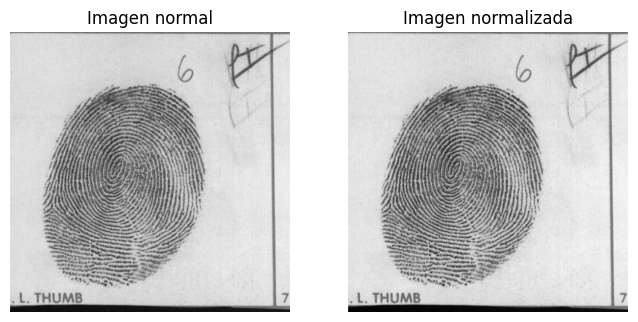

In [60]:
cvlib.imgcmp(img1, normalized, ['Imagen normal', 'Imagen normalizada'])

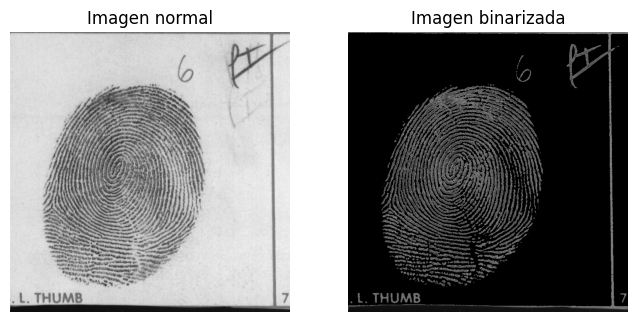

In [90]:
to_zero = cv.threshold(img1,140,255,cv.THRESH_TOZERO_INV)[1]
cvlib.imgcmp(img1, to_zero, ['Imagen normal', 'Imagen binarizada'])

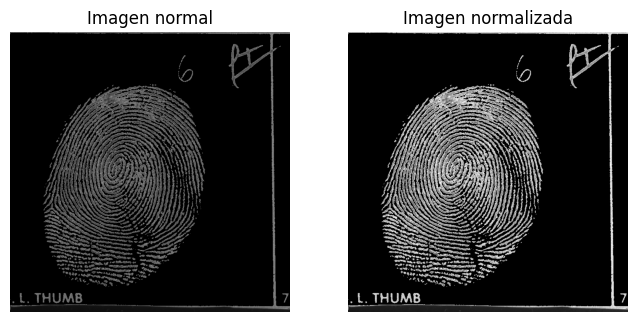

In [91]:
normalized = cvlib.imgnorm(to_zero)
cvlib.imgcmp(to_zero, normalized, ['Imagen normal', 'Imagen normalizada'])

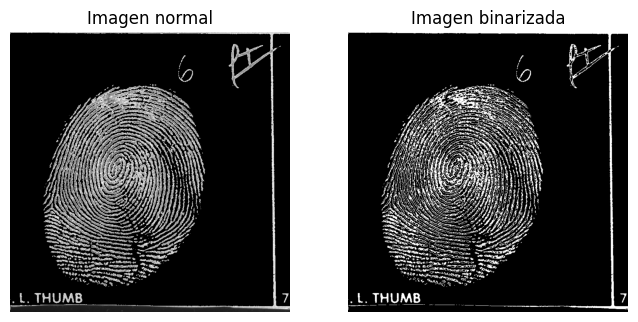

In [96]:
thresh_val = 170
# binarized = cv.threshold(trunc, 70, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)[1]
binarized = cv.threshold(normalized,thresh_val,255, cv.THRESH_BINARY)[1]
# binarized = cv.adaptiveThreshold(trunc, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,31,2)
cvlib.imgcmp(normalized, binarized, ['Imagen normal', 'Imagen binarizada'])

In [87]:
kernel = np.array([[0, 255, 0],
                   [255, 255, 255],
                   [0, 255, 0]], np.uint8)

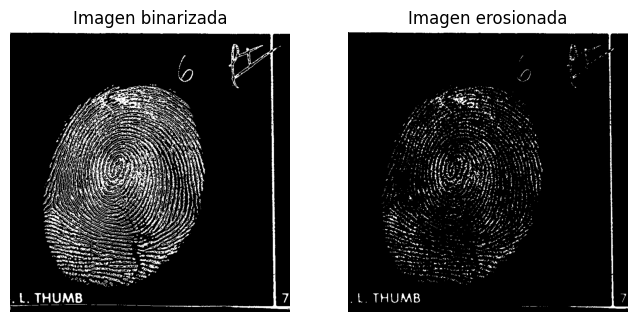

In [97]:
erosion = cv.erode(binarized, kernel, iterations=1)
cvlib.imgcmp(binarized, erosion, ['Imagen binarizada', 'Imagen erosionada'])

In [35]:
class UnionFind:
    def __init__(self, numOfElements):
        self.parent = self.makeSet(numOfElements)
        self.size = [1]*numOfElements
        self.count = numOfElements

    def makeSet(self, numOfElements):
        return [x for x in range(numOfElements)]

    def find(self, node):
        while node != self.parent[node]:
            self.parent[node] = self.parent[self.parent[node]]
            node = self.parent[node]
        return node
    
    def union(self, node1, node2):
        root1 = self.find(node1)
        root2 = self.find(node2)

        if root1 == root2:
            return

        if self.size[root1] > self.size[root2]:
            self.parent[root2] = root1
            self.size[root1] += 1
        else:
            self.parent[root1] = root2
            self.size[root2] += 1
        
        self.count -= 1

In [36]:
def neighbor(i,j,label):
    left = label[i-1,j]
    above = label[i,j-1]
    neighbor_array = [left,above]
    return neighbor_array

In [37]:
def connected_c(img):
    if type(img) != np.ndarray:
        raise TypeError("'img' must be an numpy.ndarray")
        return

    shapeY, shapeX = img.shape
    label = np.zeros([shapeY,shapeX])
    links = []
    new = 1
    #first pass
    for row in range(shapeY):
        for column in range(shapeX):
            if img[row,column] != [0]:
                current_neighbor = neighbor(row,column,label)
                if current_neighbor == [0,0]:
                    label[row, column] = new
                    new = new + 1
                else :
                    if np.min(current_neighbor) == 0 or current_neighbor[0] == current_neighbor[1] :
                        label[row,column] = np.max(current_neighbor)
                    else:
                        label[row,column] = np.min(current_neighbor)
                        links.append([np.max(current_neighbor), np.min(current_neighbor)])


    uf = UnionFind(new)

    for node1, node2 in links:
        uf.union(node1.astype(int), node2.astype(int))

    for i in range(new):
        label[label==i] = uf.find(i)

    return label

In [38]:
def get_random_color():
    """
    
    """
    return list(np.random.choice(range(256), size=3))

def labelview(img, seed = None, filename = None, size=13):
    """

    """

    if (seed != None): 
        np.random.seed(seed)

    components = np.unique(img)
    colors = {0:[0, 0, 0]}
    # print(components)

    # creacion de colores random
    for i in components:
        if i != 0: 
            colors[i] = get_random_color()
            # print(i, colors[i])        
    
    # pprint(colors)

    # colorear la imagen 
    f, c = img.shape

    img_res = []

    for i in range(0, f):
        new_row = []

        for j in range(0, c): 
            # se asigna el color que corresponde a su segmento
            segment = img[i, j]
            new_row.append(colors[segment])

        img_res.append(new_row)

    img_res = np.array(img_res)

    if filename is not None: 
        cvlib.imgview(img_res, filename = filename)
    else:
        cvlib.imgview(img_res,k=size)

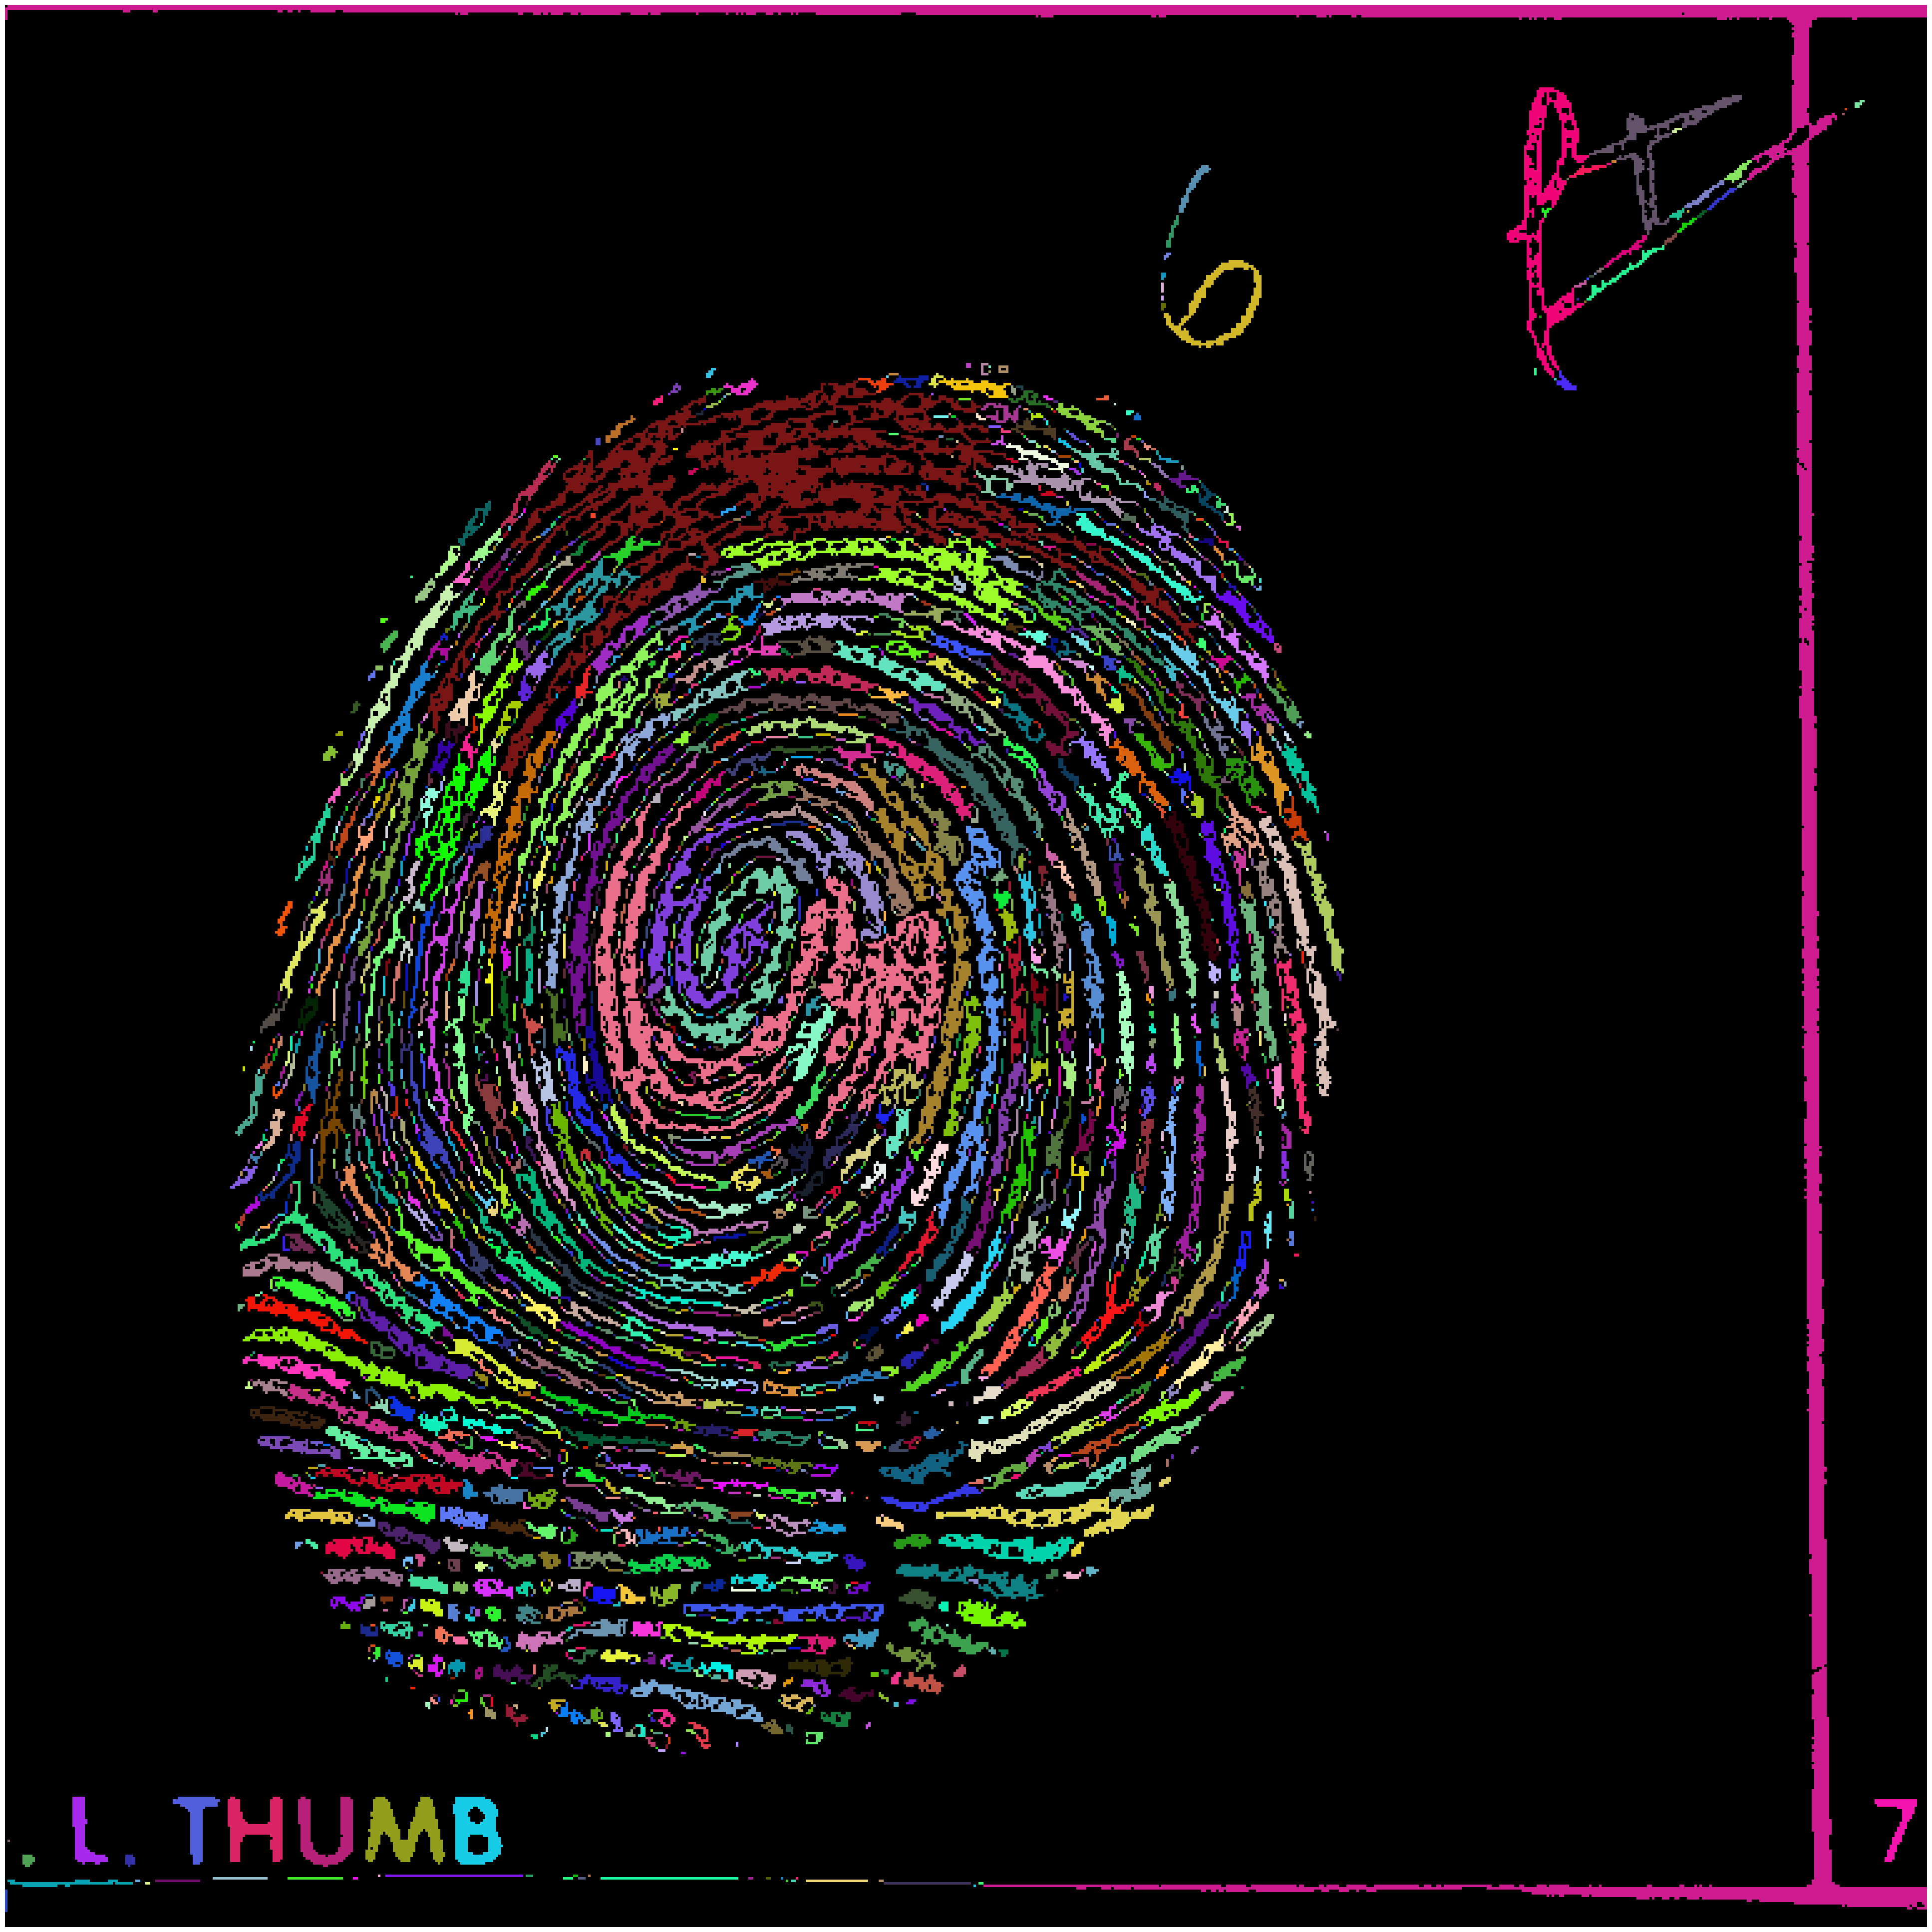

In [98]:
label = connected_c(binarized)
labelview(label,size=50)